In [1]:
import cv2
import numpy as np 
import torch 
from torchvision import transforms, models 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision


In [3]:
resnet_model = models.resnet50(weights = True)

In [4]:
from torchvision import transforms

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [6]:
from sklearn.cluster import KMeans

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
print(cv2.__version__)

4.8.1


In [11]:
dataset = torchvision.datasets.Caltech101('/Users/abhinav/Desktop/CSE515-Project', download=True)
data_loader = torch.utils.data.DataLoader(dataset,
batch_size=4,
shuffle=True,
num_workers=8)
print(len(dataset))

131740031it [00:08, 16193324.60it/s]


Extracting /Users/abhinav/Desktop/CSE515-Project/caltech101/101_ObjectCategories.tar.gz to /Users/abhinav/Desktop/CSE515-Project/caltech101


14028800it [00:00, 16346789.08it/s]


Extracting /Users/abhinav/Desktop/CSE515-Project/caltech101/Annotations.tar to /Users/abhinav/Desktop/CSE515-Project/caltech101
8677


In [12]:
from skimage.io import imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

This is ID:8000
label:92


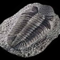

In [13]:
image_ID =8000
img, label = dataset[image_ID]
print(f'This is ID:{image_ID}')
print(f'label:{label}')
newsize = (60, 60)
img = img.resize(newsize)
display(img)

In [14]:
labels_caltech_101 = np.array([dataset[i][1] for i in range(len(dataset))])

In [15]:
print(labels_caltech_101[8676])

100


In [16]:
from PIL import Image
from torchvision import datasets
import torch
import numpy as np
from scipy.stats import skew
import csv
from tqdm import tqdm

# Initialize an empty list to store color moments
color_moments_list = []

# Initialize an empty list to store img_arrays (if needed)
all_img_arrays = []

# Loop through the dataset
for image_ID in tqdm(range(len(dataset))):
    img, label = dataset[image_ID]
    
    # Step 1: Resize the image to 300x100
    new_size = (300, 100)
    img_resized = img.resize(new_size)
    
    # Convert the PIL Image to a NumPy array
    img_array = np.array(img_resized)
    
    #grayscale image check 
    is_gray = len(img_array.shape) == 2
    
    # Append the img_array to the list (if you need to keep all arrays)
    all_img_arrays.append(img_array)

    # Step 2: Partition the image into a 10x10 grid
    for i in range(0, 300, 30):
        for j in range(0, 100, 10):
            grid_cell = img_array[j:j+10, i:i+30]
            
            # Step 3: Calculate the color moments for each grid cell
            color_moments_dict = {}
            for color_channel, color_name in enumerate(['Gray'] if is_gray else ['Red', 'Green', 'Blue']):
                channel_data = grid_cell if is_gray else grid_cell[:, :, color_channel]

                # Calculate mean, standard deviation, and skewness
                channel_mean = np.mean(channel_data)
                channel_std = np.std(channel_data)
                if np.all(channel_data == channel_data[0]):
                    channel_skewness = 0
                else :
                    channel_skewness = skew(channel_data.reshape(-1))
                
                # Store the color moments in the dictionary
                color_moments_dict[f"{color_name}_Mean"] = channel_mean
                color_moments_dict[f"{color_name}_Std"] = channel_std
                color_moments_dict[f"{color_name}_Skewness"] = channel_skewness
            
            # Include the ImageID
            color_moments_dict["ImageID"] = image_ID
            
            # Append the color moments to the list
            color_moments_list.append(color_moments_dict)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [05:56<00:00, 24.31it/s]


#### Use hog_features_dict as the feature matrix

In [17]:
from torchvision import datasets
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize
from PIL import Image
import numpy as np
from tqdm import tqdm

# Assuming you've already loaded the dataset like this:
# dataset = datasets.Caltech101('/path/to/dataset', download=True)

def extract_hog_features(image):
    # Convert PIL Image to NumPy array
    image_np = np.array(image)
    
    # Check if the image is grayscale
    if len(image_np.shape) == 2:
        gray_image = image_np
    else:
        gray_image = rgb2gray(image_np)
    
    # Resize the image
    resized_image = resize(gray_image, (300, 100))
    
    # Compute the HOG features
    features, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(30, 10),
                              cells_per_block=(1, 1), visualize=True)
    
    return features, hog_image

# Initialize empty dictionaries to store features and labels
hog_features_dict = {}
hog_images_dict = {}
labels_dict = {}

# Loop over the dataset with progress bar
for i in tqdm(range(len(dataset)), desc="Extracting HOG features"):
    image, label = dataset[i]
    features, hog_image = extract_hog_features(image)
    hog_features_dict[i] = features
    hog_images_dict[i] = hog_image
    labels_dict[i] = label

# Now:
# hog_features_dict contains the 900-dimensional feature descriptor for each image, indexed by dataset index
# hog_images_dict contains the visual representation of the HOG features for each image, indexed by dataset index
# labels_dict contains the label for each image, indexed by dataset index


Extracting HOG features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [01:04<00:00, 133.71it/s]


In [18]:
print(len(hog_features_dict))

8677


In [19]:
print(len(color_moments_list))

867700


In [20]:
# Resnet computations 
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.53994344, 0.52009986, 0.49254049], 
                         [0.31415099, 0.30712622, 0.31878401]),  # Normalize the images
])

def resnet_computations(hook_layer, dataset):
    
    # List to store the output tensors for each image along with their ImageID
    outputs_with_ids = []
    skipped_images = []
    
    # List to temporarily capture the output tensor from the hook
    captured_output = [None]

    # Hook function to capture the output tensor of a specified layer
    def capture_output(module, input, output):
        captured_output[0] = output

    # Register the hook function to the specified layer
    if hook_layer == 'avgpool':
        hook = resnet_model.avgpool.register_forward_hook(capture_output)
    elif hook_layer == 'layer3':
        hook = resnet_model.layer3.register_forward_hook(capture_output)
    elif hook_layer == 'fc':   
        hook = resnet_model.fc.register_forward_hook(capture_output)

    # Loop through the dataset
    for i in tqdm(range(len(dataset))):
        try:
            img, label = dataset[i]
            #skipping grayscale images 
            if img.mode == 'L' or img.mode == '1':
                img = img.convert("RGB")

            # Apply transformations and prepare image batch
            img_tensor = transform(img)
            img_batch = img_tensor.unsqueeze(0)  # Add a batch dimension

            # Forward pass (disable gradient computation to save memory)
            with torch.no_grad():
                resnet_model(img_batch)
            
            # Retrieve the captured output tensor
            resnet_output = captured_output[0]
            if resnet_output is None:
                print("Warning: Hook Not Triggered")
                skipped_images.append(i)
                continue

            # Process the output tensor depending on the specified layer and store it in a dictionary
            output_dict = {"ImageID": i}
            if hook_layer == 'avgpool':
                avgpool_output = resnet_output.flatten().cpu().numpy()
                averaged_values = [(avgpool_output[i] + avgpool_output[i+1]) / 2.0 for i in range(0, len(avgpool_output), 2)]
                output_dict["Output"] = np.array(averaged_values)
            elif hook_layer == 'layer3':
                avg_vector = resnet_output.mean(dim=[2, 3]).cpu().numpy().squeeze()
                output_dict["Output"] = avg_vector
            elif hook_layer == 'fc':
                output_dict["Output"] = resnet_output.cpu().numpy().squeeze()
            
            # Append the dictionary to the list
            outputs_with_ids.append(output_dict)
        except Exception as e:
            print(f"Error processing ImageID {i}: {e}")
            skipped_images.append(i)
    # Remove the hook to free resources
    hook.remove()
    
    return outputs_with_ids

In [21]:
output_avgpool_with_ids = resnet_computations('avgpool',dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [05:39<00:00, 25.57it/s]


In [22]:
print(len(output_avgpool_with_ids))

8677


In [23]:
output_layers3_with_ids = resnet_computations('layer3',dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [05:38<00:00, 25.64it/s]


In [24]:
print(len(output_layers3_with_ids))

8677


In [25]:
output_fc_with_ids = resnet_computations('fc',dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [05:40<00:00, 25.47it/s]


In [27]:
print(len(output_fc_with_ids))

8677


In [24]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

In [26]:
from tqdm import tqdm

In [86]:
# import pandas as pd 
# df_color_moments = pd.read_csv("color_moments_with_imageID.csv")

In [85]:
# print(len(df_color_moments))

In [87]:
# feature_columns = df_color_moments.columns[1:-1]
# data_color_moments = df_color_moments[feature_columns].values

In [88]:
# print(feature_columns)

In [89]:
# print(data_color_moments[0]) 

In [44]:
from sklearn.decomposition import TruncatedSVD

In [50]:
# k = 5 
# svd = TruncatedSVD(n_components = k)
# latent_semantics = svd.fit_transform(data_color_moments)
# print("Reduced Data:(Latent Semantics)")
# print(latent_semantics)

In [232]:
def SVD_calc(feature_matrix,k):
    #print("Enter SVD calc")
    svd = TruncatedSVD(n_components=k)
    latent_semantics = svd.fit_transform(feature_matrix)
    #print("The latent semantics are:")
    print(latent_semantics)
    return latent_semantics

In [51]:
from sklearn.decomposition import NMF 

In [52]:
def NMF_calculator(feature_matrix,k):
    nmf = NMF(n_components=k)
    W = nmf.fit_transform(feature_matrix)
    H = nmf.components_
    return H 

In [215]:
def LDA_calculator(feature_matrix,k):
    lda = LinearDiscriminantAnalysis(n_components = k)
    lda_result = lda.fit_transform(feature_matrix,labels_caltech_101)
    top_k_latent = lda.scalings_[:, :k]
    return top_k_latent
    

In [75]:
def k_means_calculator(feature_matrix,k):
    kmeans = KMeans(n_clusters = k,random_state=0)
    kmeans.fit(feature_matrix)
    top_k_latent_semantics = kmeans.cluster_centers_
    return top_k_latent_semantics

## Below Is the Code Of Block of converting the Phase 1 results into feature matrices

In [94]:
# import pandas as pd 
# df_color_moments = pd.read_csv("color_moments_with_imageID.csv")
# feature_columns = df_color_moments.columns[1:-1]
# data_color_moments = df_color_moments[feature_columns].values
# print(feature_columns)
# print(data_color_moments[0]) 

#### In the Below code block use data_color_moments as the feature matrix for SVD 
#### Use the X_color_moments for NMF and X_standardized_color_moments for remaining

In [161]:

import pandas as pd 
color_moments_df = pd.DataFrame(color_moments_list)
color_moments_df.fillna(color_moments_df.mean(), inplace=True)
data_color_moments= color_moments_df.drop(columns="ImageID").to_numpy()
n_grids_per_image = 10 * 10  # 10x10 grid for each image
n_features_per_grid = data_color_moments.shape[1]
X_color_moments = data_color_moments.reshape(len(dataset), n_grids_per_image * n_features_per_grid)


In [162]:
scaler_2 = StandardScaler()
X_standardized_color_moments = scaler_2.fit_transform(X_color_moments)

In [166]:
#print(X_standardized_color_moments[0])

In [100]:
print(len(X_color_moments))

8677


#### Use X_hog for nmf and X_hog_standardized for remaining

In [125]:

X_hog = np.array(list(hog_features_dict.values()))
scaler = StandardScaler()
X_hog_standardized = scaler.fit_transform(X_hog)


In [165]:
#print(X_hog_standardized[0])

#### Feature Matrix Conversion of Resnet computations

In [201]:
X_resnet_avgpool = np.array([entry["Output"] for entry in output_avgpool_with_ids])
X_resnet_layers3 = np.array([entry["Output"] for entry in output_layers3_with_ids])
X_resnet_fc = np.array([entry["Output"] for entry in output_fc_with_ids])


In [204]:
print(len(X_resnet_layers3))

8677


#### Use X_resnet_{layer_value} for NMF and X_standardized_resnet_{layer_value} for remaining reduction technique

In [202]:
#Standardizing the data 
scaler_1 = StandardScaler()
X_standardized_resnet_avgpool = scaler_1.fit_transform(X_resnet_avgpool)
X_standardized_resnet_layers3 = scaler_1.fit_transform(X_resnet_layers3)
X_standardized_resnet_fc = scaler_1.fit_transform(X_resnet_fc)

In [207]:
print(len(X_standardized_resnet_fc))

8677


In [167]:
#print(X_standardized_resnet_fc[0])

##  Create the UI here and call appropriate functions


In [208]:
def get_feature_model_data(feature_model):
    if feature_model == "Color Moments":
        X_data = X_color_moments
        X_standardized = X_standardized_color_moments
    elif feature_model == "HOG Descriptor":
        X_data = X_hog
        X_standardized = X_hog_standardized
    elif  feature_model == "Resnet FC":
        X_data = X_resnet_fc
        X_standardized = X_standardized_resnet_fc
    elif feature_model == "Resnet Avgpool":
        X_data = X_resnet_avgpool
        X_standardized= X_standardized_resnet_avgpool 
    elif feature_model == "Resnet Layer 3":
        X_data = X_resnet_layers3
        X_standardized= X_standardized_resnet_layers3
    else:
        return -1
    return X_data,X_standardized
        

In [236]:
def dimensionality_reduction(X_data,X_standardized,technique,k):
    if technique == 'SVD':
        #print("Entered SVD")
        result = SVD_calc(X_standardized,k)
    elif technique == 'NNMF':
        result = NMF_calculator(X_data,k)
    elif technique =='LDA':
        result = LDA_calculator(X_standardized,k)
    elif technique == 'k-means':
        result = k_means_calculator(X_standardized,k)
    else :
        return -1
    return result

In [238]:
def main():
    #Select a Feature Model
    # Prompt user for feature model
    print("Choose a feature model:")
    print("1. Color Moments")
    print("2. HOG Descriptor")
    print("3. Resnet FC")
    print("4. Resnet Avgpool")
    print("5. Resnet Layer 3")
    feature_model_choice = input("Enter your choice(number): ")
    # Convert choice to string name
    feature_model = ["Color Moments", "HOG Descriptor", "Resnet FC", "Resnet Avgpool", "Resnet Layer 3"][int(feature_model_choice) - 1]
    #print(feature_model)
    X_data, X_standardized_data = get_feature_model_data(feature_model)
#Select the Dimensionality Reduction Technique 
    k = int(input('Please Enter the value of k'))
    # Prompt user for dimensionality reduction technique
    print("\nChoose a dimensionality reduction technique:")
    print("1. SVD")
    print("2. NNMF")
    print("3. LDA")
    print("4. k-means")
    technique_choice = input("Enter your choice: ")
    #Convert choice to specified string 
    technique = ["SVD", "NNMF", "LDA", "k-means"][int(technique_choice) - 1]
    result = dimensionality_reduction(X_data,X_standardized_data,technique,k,)
    print(f"top {k} latent-semantics of {feature_model} using {technique}")
    print(result)


In [239]:
main()

Choose a feature model:
1. Color Moments
2. HOG Descriptor
3. Resnet FC
4. Resnet Avgpool
5. Resnet Layer 3

Choose a dimensionality reduction technique:
1. SVD
2. NNMF
3. LDA
4. k-means
[[  0.058179     0.03328266  -4.63146497 ...  -5.92938044  -2.96327335
   -1.64448583]
 [  7.88788642  -0.10018586   4.0832809  ...   1.34306705  -1.67159542
    0.08110227]
 [ -6.19782064  -0.03761281  -1.14583625 ...  -5.4032408   -0.82234513
   -1.75852333]
 ...
 [-10.06320898  -0.18002127   2.10457802 ...  -4.5335982    3.62428075
   -0.37549492]
 [  1.26859816  13.25711803  -4.13699945 ...  22.73296103  -7.63288573
  -31.15577838]
 [-13.59723828  -0.19151409   3.80929369 ... -12.86814475  -5.69114587
   -0.81008176]]
top 10 latent-semantics of Color Moments using SVD
[[  0.058179     0.03328266  -4.63146497 ...  -5.92938044  -2.96327335
   -1.64448583]
 [  7.88788642  -0.10018586   4.0832809  ...   1.34306705  -1.67159542
    0.08110227]
 [ -6.19782064  -0.03761281  -1.14583625 ...  -5.4032408   -

In [46]:
len(labels_caltech_101)

8677

In [35]:
print(len(hog_features_dict))

8677


In [44]:
len(hog_features_dict[0])

900

In [36]:
print(len(color_moments_list))

867700


In [80]:
color_moments_list[0]

{'Red_Mean': 100.75,
 'Red_Std': 41.33296706826969,
 'Red_Skewness': 0.15939082768196947,
 'Green_Mean': 99.26666666666667,
 'Green_Std': 45.024166350478446,
 'Green_Skewness': 0.17302136897815748,
 'Blue_Mean': 93.96333333333334,
 'Blue_Std': 46.95034954313144,
 'Blue_Skewness': 0.11821055484499522,
 'ImageID': 0}

In [37]:
print(len(output_avgpool_with_ids))

8677


In [101]:
len(output_avgpool_with_ids[435]['Output'])

1024

In [38]:
print(len(output_layers3_with_ids))

8677


In [39]:
print(len(output_fc_with_ids))

8677


HOG TENSOR CREATION

In [47]:
import numpy as np

def create_empty_tensor(num_images, feature_length, num_labels):
    """
    Creates an empty tensor filled with zeros.
    """
    return np.zeros((num_images, feature_length, num_labels))

def get_label_index(label, all_labels):
    """
    Returns the index of the given label in the all_labels list.
    """
    return all_labels.index(label)

def construct_tensor(feature_vectors, labels_list, all_labels):
    num_images = len(feature_vectors)
    feature_length = len(next(iter(feature_vectors.values())))  # Length of a feature vector
    num_labels = len(all_labels)

    tensor = create_empty_tensor(num_images, feature_length, num_labels)

    for idx, feature in enumerate(feature_vectors.values()):
        # Set the feature vector in the tensor
        tensor[idx, :, :] = np.array(feature)[:, np.newaxis]

        # Set the label in the tensor
        label = labels_list[idx]
        label_index = get_label_index(label, all_labels)
        tensor[idx, :, label_index] = 1

    return tensor

    

In [48]:
hog_tensor = construct_tensor(hog_features_dict, labels_caltech_101, list(set(labels_caltech_101)))

In [ ]:
torch.save(hog_tensor, 'hog_tensor_file.pt')

In [51]:
hog_tensor.shape

(8677, 900, 101)

COLOR MOMENTS TENSOR CREATION

In [67]:
def construct_color_moments_tensor(data_list):
    num_images = len(data_list) // 100
    features_per_element = 9 # Max 9 for RGB
    elements_per_image = 100

    tensor = np.zeros((num_images, features_per_element * elements_per_image, len(set(labels_caltech_101))))

    for i in range(num_images):
        for j in range(elements_per_image):
            element = data_list[i*100 + j]
            if 'Red_Mean' in element:  # RGB features
                features = [element[key] for key in ['Red_Mean', 'Red_Std', 'Red_Skewness',
                                                     'Green_Mean', 'Green_Std', 'Green_Skewness',
                                                     'Blue_Mean', 'Blue_Std', 'Blue_Skewness']]
            else:  # Grayscale features
                features = [element[key] for key in ['Gray_Mean', 'Gray_Std', 'Gray_Skewness']]
                # Padding to match the RGB feature length
                features.extend([0] * (9 - len(features)))
            
            start_idx = j * features_per_element
            end_idx = start_idx + features_per_element
            tensor[i, start_idx:end_idx, j] = features

    return tensor

In [73]:
color_moments_tensor.shape

(8677, 900, 101)

In [68]:
color_moments_tensor = construct_color_moments_tensor(color_moments_list)

In [87]:
# Print a tensor

index_to_extract = 0
extracted_tensor = color_moments_tensor[index_to_extract, :, :]

# Printing the entire 2D tensor without truncation by iterating through its rows and columns
output_data = []
for row in extracted_tensor:
    output_data.append(list(row))

# output_data

RESNET TENSOR CREATION

In [108]:
len(labels_caltech_101)

8677

In [109]:
def construct_resnet_tensor(data_list):
    num_images = len(data_list)
    feature_length = len(data_list[0]['Output'])
    
    tensor = np.zeros((num_images, feature_length, len(set(labels_caltech_101))))

    for i, element in enumerate(data_list):
        features = element['Output']
        label_index = labels_caltech_101[i]
        tensor[i, :, label_index] = features

    return tensor

In [113]:
resnet_avgpool_tensor = construct_resnet_tensor(output_avgpool_with_ids)

In [114]:
resnet_avgpool_tensor.shape

(8677, 1024, 101)

In [115]:
resnet_layer3_tensor = construct_resnet_tensor(output_layers3_with_ids)

In [116]:
resnet_layer3_tensor.shape

(8677, 1024, 101)

In [117]:
resnet_fc_tensor = construct_resnet_tensor(output_fc_with_ids)

In [118]:
resnet_fc_tensor.shape

(8677, 1000, 101)

Main function for CP decomposition

In [121]:
import tensorly as tl
from tensorly.decomposition import parafac

feature_tensor = {
    1: hog_tensor,
    2: color_moments_tensor,
    3: resnet_avgpool_tensor,
    4: resnet_layer3_tensor,
    5: resnet_fc_tensor
}

# 1: HOG
# 2: Color Moments
# 3: Resnet Avgpool
# 4: Resnet Layer3
# 5: Resnet FC

def extract_latent_semantics(tensor, k, labels):
    # Perform CP-decomposition
    weights, factors = parafac(tensor, rank=k)
    
    # Extract the weights for the label mode (assuming it's the last mode)
    label_weights = factors[2]
    
    # Sort the weights and associate with labels
    sorted_indices = label_weights.argsort(axis=0)[::-1].flatten()
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_weights = label_weights[sorted_indices].flatten()
    
    # Prepare the label-weight pairs
    label_weight_pairs = list(zip(sorted_labels, sorted_weights))
    
    return label_weight_pairs

def save_to_file(label_weight_pairs, filename):
    with open(filename, 'w') as f:
        for label, weight in label_weight_pairs:
            f.write(f"{label}: {weight}\n")

def main_task_4(feature_model_id, k):
    tensor = feature_tensor[feature_model_id]
    labels = set(labels_caltech_101)
    
    latent_semantics = extract_latent_semantics(tensor, k, labels)
    save_to_file(latent_semantics, "latent_semantics_output.txt")
        

In [ ]:
main(1,1)

In [155]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

def create_label_similarity_matrix(tensor):
    # Summing across the image and feature dimensions to get label representations
    label_representations = np.sum(tensor, axis=(0, 1))
    
    # Compute pairwise Euclidean distances
    distances = pdist(label_representations.reshape(-1, 1), metric='euclidean')
    square_distances = squareform(distances)
    
    # Convert distances to similarities
    similarities = 1 / (1 + square_distances)
    
    return similarities


def dimensionality_reduction(matrix, method, k):
    if method == "SVD":
        svd = TruncatedSVD(n_components=k)
        reduced_matrix = svd.fit_transform(matrix)
    elif method == "NNMF":
        nmf = NMF(n_components=k)
        reduced_matrix = nmf.fit_transform(matrix)
    elif method == "LDA":
        lda = LatentDirichletAllocation(n_components=k)
        reduced_matrix = lda.fit_transform(matrix)
    elif method == "k-means":
        kmeans = KMeans(n_clusters=k)
        reduced_matrix = kmeans.fit_transform(matrix)
    else:
        raise ValueError(f"Unknown method: {method}")
    return reduced_matrix

def save_to_file(matrix, filename):
    np.savetxt(filename, matrix)

def main_task_5(feature_model_id, k, reduction_method):
    tensor = feature_tensor[feature_model_id]
    similarity_matrix = create_label_similarity_matrix(tensor)
    reduced_matrix = dimensionality_reduction(similarity_matrix, reduction_method, k)
    
    # Save latent semantics
    # filename = f"latent_semantics_{reduction_method}.txt"
    # save_to_file(reduced_matrix, filename)
    
    # List label-weight pairs
    label_weights = np.sum(reduced_matrix, axis=1)
    sorted_indices = label_weights.argsort()[::-1]
    sorted_labels = [labels_caltech_101[i] for i in sorted_indices]
    sorted_weights = label_weights[sorted_indices]
    label_weight_pairs = list(zip(sorted_labels, sorted_weights))
    return label_weight_pairs


In [156]:
main_task_5(4, 4, "k-means")

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[(0, 5.966975521739771),
 (0, 5.9668464785790585),
 (0, 5.449396927653185),
 (0, 5.379511073161442),
 (0, 5.314395832865798),
 (0, 5.314180414053493),
 (0, 5.283544098868186),
 (0, 5.1676549259559685),
 (0, 5.167262695217472),
 (0, 5.154901449934496),
 (0, 5.142179600113071),
 (0, 5.141815097706982),
 (0, 5.133609249237595),
 (0, 5.13118401831645),
 (0, 5.127953904826918),
 (0, 5.121690857935883),
 (0, 5.117607868995081),
 (0, 5.1138607850439115),
 (0, 5.111837764249434),
 (0, 5.111575192674),
 (0, 5.111322033266526),
 (0, 5.110638923147751),
 (0, 5.108204299068233),
 (0, 5.108160202227085),
 (0, 5.104044128507998),
 (0, 5.102041187321486),
 (0, 5.101201397588099),
 (0, 5.101131116028064),
 (0, 5.1009156189672495),
 (0, 5.099940027769826),
 (0, 5.0999302747466215),
 (0, 5.099703244923324),
 (0, 5.099683865370208),
 (0, 5.099118392125359),
 (0, 5.098757118344783),
 (0, 5.097307610699725),
 (0, 5.097065903979004),
 (0, 5.09680978550564),
 (0, 5.096242157670581),
 (0, 5.0960438934395835),